<a href="https://colab.research.google.com/github/soobin2121/ML_EDU/blob/master/%EC%8A%A4%ED%83%80%EB%B2%85%EC%8A%A4%EC%99%80_%EC%9D%B4%EB%94%94%EC%95%BC_%EC%83%81%EA%B6%8C%EB%B9%84%EA%B5%90%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 소상공인 시장진흥공단 상가업소정보로 스타벅스, 이디야 위치 분석하기

### 필요한 라이브러리 불러오기 + 한글폰트 설정

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
mpl.font_manager._rebuild()

plt.rc("font", family="NanumBarunGothic")
plt.rc("axes", unicode_minus=False)

In [ ]:
# 폰트가 선명하게 보이도록 retina 설정

from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

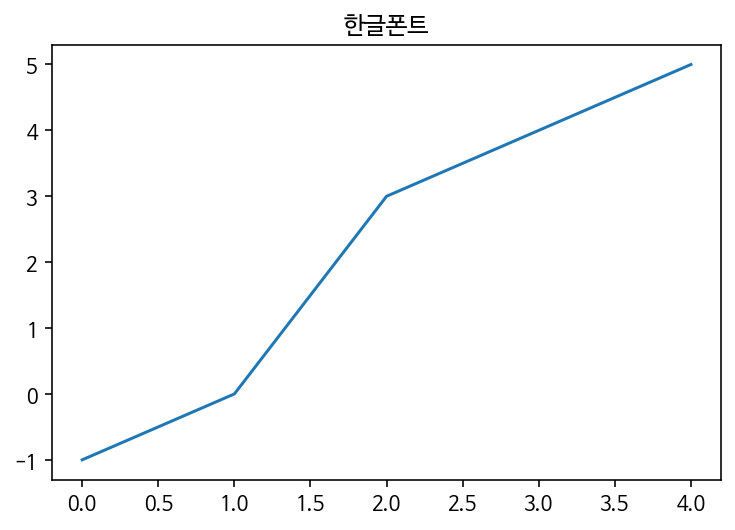

In [ ]:
# 한글폰트 확인

pd.Series([-1,0,3,4,5]).plot(title='한글폰트')

## colab 용 googleAuth 인증

In [ ]:
# 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

 # PyDrive client 인증
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# 공유 가능한 링크로 파일 가져오기
url = 'https://drive.google.com/open?id=1e91PH_KRFxNXUsx8Hi-Q2vPiorCDsOP4'
id = url.split('=')[1]
print(id)
downloaded = drive.CreateFile({'id':id}) 

# # data 폴더에 파일을 관리하며, 폴더가 없다면 만들어서 파일을 관리하도록 한다.
%mkdir data
downloaded.GetContentFile('data/상가업소정보_201912_01.csv')  

1e91PH_KRFxNXUsx8Hi-Q2vPiorCDsOP4


## 데이터 불러오기

In [ ]:
df= pd.read_csv('data/상가업소정보_201912_01.csv', sep='|')
df.shape

(573680, 39)

### 데이터 미리보기

In [ ]:
df.head(3)

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

### 사용하지 않는 데이터 삭제하기

In [ ]:
columns=['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', 
       '시도명', '시군구명', '행정동명', '법정동명', 
       '도로명주소', '경도', '위도']

df= df[columns].copy()
df.head()       

,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도명,시군구명,행정동명,법정동명,도로명주소,경도,위도
0,와라와라호프,음식,유흥주점,호프/맥주,서울특별시,강남구,대치1동,대치동,서울특별시 강남구 남부순환로 2933,127.061026,37.493922
1,커피빈코리아선릉로93길점,음식,커피점/카페,커피전문점/카페/다방,서울특별시,강남구,역삼1동,역삼동,서울특별시 강남구 선릉로93길 6,127.047883,37.505675
2,프로포즈,음식,유흥주점,호프/맥주,서울특별시,금천구,독산3동,독산동,서울특별시 금천구 가산로 34-6,126.899220,37.471711
3,싱싱커피&토스트,음식,패스트푸드,토스트전문,부산광역시,사상구,괘법동,괘법동,부산광역시 사상구 괘감로 37,128.980455,35.159774
4,가락사우나내스낵,생활서비스,대중목욕탕/휴게,사우나/증기탕/온천,서울특별시,송파구,석촌동,석촌동,서울특별시 송파구 가락로 71,127.104071,37.500249


## 색인으로 서브셋 가져오기

### 서울만 따로 보기

In [ ]:
df_seoul= df[df['시도명']=='서울특별시'].copy()
df_seoul.head()

### 일부 텍스트가 들어간 데이터만 가져오기
- 상호명에서 브랜드명을 추출
- 대소문자가 섞여있을 수 있기 때문에, 대소문자 변환


In [ ]:
df_seoul['상호명_소문자']= df_seoul['상호명'].str.lower()

In [ ]:
df_seoul.loc[df_seoul['상호명_소문자'].str.contains('이디야|이디야|ediya'), '상호명_소문자']

In [ ]:
df_seoul.loc[df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks'),'상호명_소문자']

In [ ]:
df_cafe=df_seoul.loc[df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks|이디야|이디야|ediya')].copy()

In [ ]:
df_cafe.loc[df_cafe['상호명_소문자'].str.contains('스타벅스|starbucks'),'브랜드명']= '스타벅스'
df_cafe.loc[df_cafe['상호명_소문자'].str.contains('이디야|이디야|ediya'),'브랜드명']= '이디야'
df_cafe[['브랜드명','상호명_소문자']].head()

In [ ]:
df_cafe[['브랜드명','상호명']].tail()

### 시각화

In [ ]:
df_cafe=df_cafe[df_cafe['상권업종중분류명']=='커피점/카페'].copy()
df_cafe.shape

(1007, 13)

In [ ]:
df_cafe['브랜드명'].value_counts()

스타벅스    504
이디야     503
Name: 브랜드명, dtype: int64

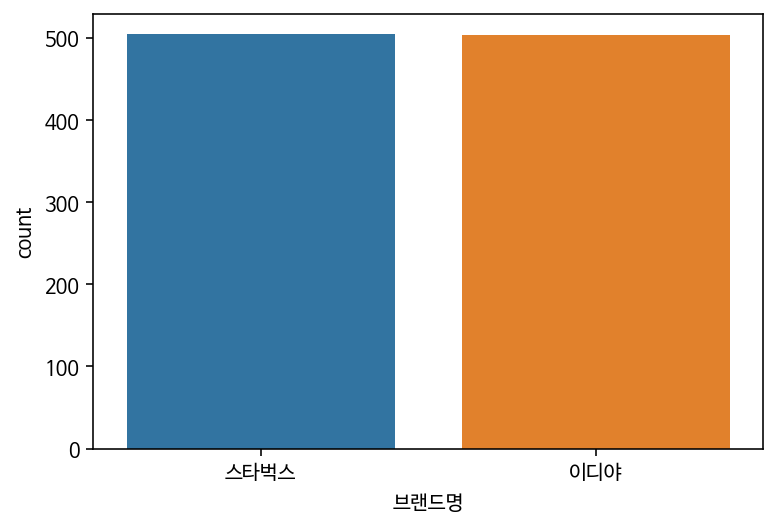

In [ ]:
#df_cafe['브랜드명'].value_counts().plot.bar()

sns.countplot(data=df_cafe, x='브랜드명')

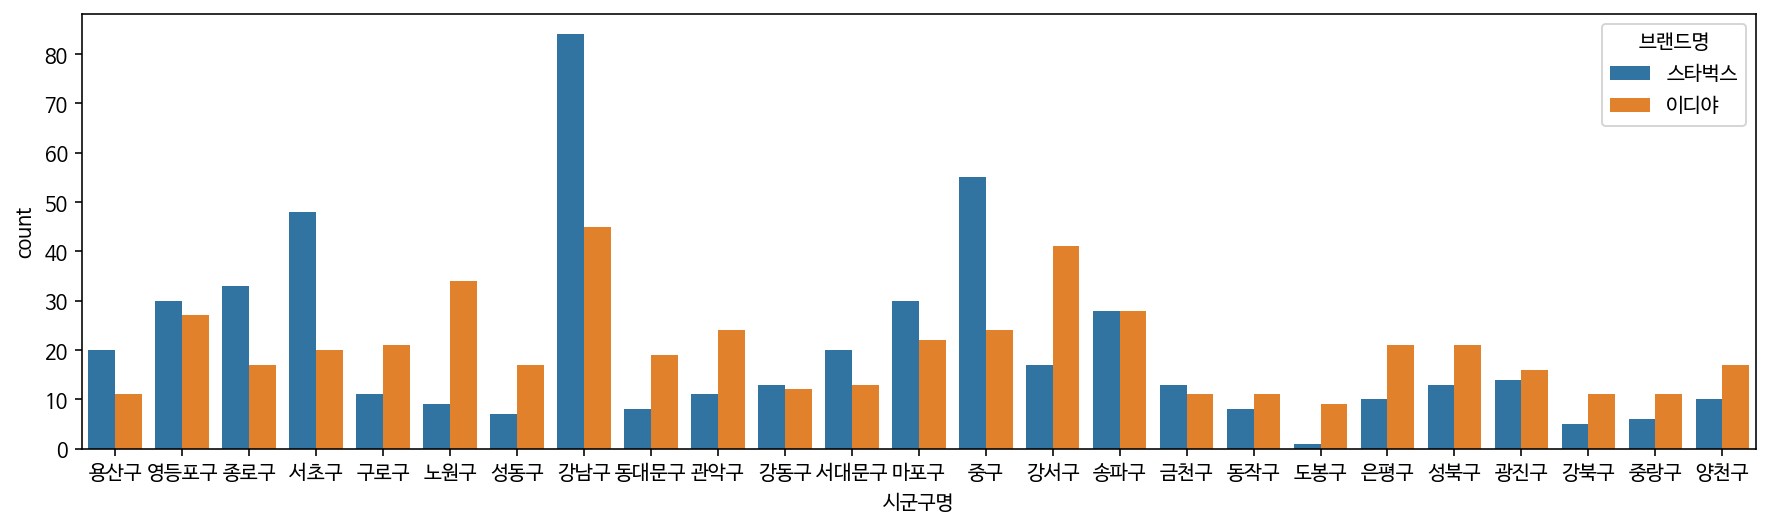

In [ ]:
plt.figure(figsize=(15,4))
sns.countplot(data=df_cafe, x='시군구명', hue='브랜드명')

#### scatterplot 그리기

In [ ]:
df_cafe[['위도','경도']].plot.scatter(x='경도',y='위도')

In [ ]:
sns.scatterplot(data=df_cafe, x='경도',y='위도', hue='브랜드명')

#### jointplot 그리기

In [ ]:
sns.jointplot(data=df_cafe, x='경도', y='위도', kind='kde')

### 구별 브랜드별 점포수

#### groupby 로 구별 매장수 구하기

In [ ]:
df_cafe_vs= df_cafe.groupby(['시군구명','브랜드명'])['상호명'].count()

# 프레임화
df_cafe_vs.to_frame().head()

# 인덱스를 컬럼으로 만들기
df_cafe_vs= df_cafe_vs.reset_index()
df_cafe_vs.head()

,시군구명,브랜드명,상호명
0,강남구,스타벅스,84
1,강남구,이디야,45
2,강동구,스타벅스,13
3,강동구,이디야,12
4,강북구,스타벅스,5


In [ ]:
df_cafe_vs.columns=['구','브랜드명','매장수']

#### pivot_table 로 구별 매장수 구하기

In [ ]:
pivot= pd.pivot_table(data=df_cafe, index=['시군구명','브랜드명'], values='상호명', aggfunc='count')
pivot.head()

In [ ]:
pivot.loc['강남구']

## Folium 으로 지도 활용하기
- anaconda prompt 에서 설치(관리자권한으로 열기)

-conda install -c conda-forge folium

In [ ]:
import folium

In [ ]:
lat= df_cafe['위도'].mean()
long= df_cafe['경도'].mean()
lat, long 

(37.542801742234346, 126.98901433177834)

### 스타벅스, 이디야 카페 매장 전체 분포

In [ ]:
m = folium.Map([lat, long], zoom_start=12, tiles="Stamen Toner")

for i in df_cafe.index:
    sub_lat = df_cafe.loc[i, "위도"]
    sub_long = df_cafe.loc[i, "경도"]
    
    title = f"{df_cafe.loc[i, '상호명']} - {df_cafe.loc[i, '도로명주소']}"
    
    color = "green"
    if df_cafe.loc[i, "브랜드명"] == "이디야":
        color = "blue"
    
    folium.CircleMarker([sub_lat, sub_long],
                        radius=3,
                        color=color,
                          tooltip=title).add_to(m)
m                          

### choropleth 를 위한 GeoJSON 파일로드
- 노트북에서 json 파일 업로드 하고 불러왔음.

In [ ]:
from google.colab import files
myfile = files.upload()

Saving seoul_municipalities_geo_simple.json to seoul_municipalities_geo_simple.json


In [ ]:
import json

geo_json = json.load(open('seoul_municipalities_geo_simple.json'))
geo_json['features'][0]['properties']['name']

'강동구'

In [ ]:
df_star = df_cafe_vs[df_cafe_vs["브랜드명"] == "스타벅스"].copy()
df_star.head()

In [ ]:
m = folium.Map([lat, long])

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_star,
    columns=['구', '매장수'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='스타벅스 매장수'
).add_to(m)

m

In [ ]:
df_ediya = df_cafe_vs[df_cafe_vs["브랜드명"] == "이디야"].copy()
df_ediya.head()

In [ ]:
m = folium.Map([lat, long], tiles='stamen toner')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_ediya,
    columns=['구', '매장수'],
    key_on='feature.properties.name',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='이디야 매장수'
).add_to(m)


for i in df_cafe.index:
    sub_lat = df_cafe.loc[i, "위도"]
    sub_long = df_cafe.loc[i, "경도"]
    
    title = f"{df_cafe.loc[i, '상호명']} - {df_cafe.loc[i, '도로명주소']}"
    
    color = "green"
    if df_cafe.loc[i, "브랜드명"] == "이디야":
        color = "blue"
    
    folium.CircleMarker([sub_lat, sub_long],
                        radius=3,
                        color=color,
                          tooltip=title).add_to(m)

m